# Part 2a. Logistic Regression(Classifying Activities)

### 1. Load libraries

In [12]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

### 2. Split train-test datasets

In [13]:
df_train = pd.read_csv("source/train.csv")
df_test = pd.read_csv("source/test.csv")

y_train = df_train.Activity
x_train = df_train.drop(['subject', 'Activity'], axis=1)

y_test = df_test.Activity
x_test = df_test.drop(['subject', 'Activity'], axis=1)

### 3. Build Logistic Regression before Hyperparameter Tuning

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

logistic_model1 = LogisticRegression()
logistic_model1.fit(x_train, y_train)
y_pred = logistic_model1.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

####  a) Accuracy

In [15]:
accuracy = logistic_model1.score(x_test, y_test)
print("Accuracy:",accuracy)

Accuracy: 0.9579233118425518


#### b) Confusion Table

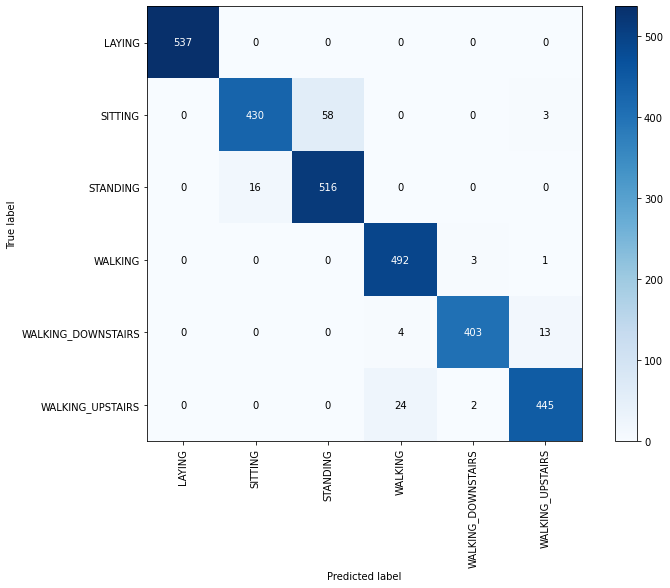

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(cm, cmap=plt.cm.Blues)
ax.figure.colorbar(ax.imshow(cm, cmap=plt.cm.Blues), ax=ax)
ax.set(
    xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=np.unique(y_pred),
    yticklabels=np.unique(y_pred),
    ylabel="True label",
    xlabel="Predicted label",
)
plt.xticks(rotation = 90)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]),ha="center", va="center",color="white" if cm[i, j] > thresh else "black")

### 4. Build Logistic Regression with Hyperparameter Tuning

In [17]:
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV
space = dict()
space['solver'] = ['lbfgs']
space['penalty'] = ['l1', 'l2']
space['C'] = loguniform(1e-5, 10)
search = RandomizedSearchCV(logistic_model1, space, n_iter=30, scoring='accuracy', n_jobs=-1, cv=5, random_state=1)
hypermodel = search.fit(x_train,y_train)

#### a) Accuracy

In [18]:
y_pred1 = hypermodel.predict(x_test)
cm1 = confusion_matrix(y_test, y_pred1)
accuracy = hypermodel.score(x_test, y_test)
print("Accuracy:",accuracy)

Accuracy: 0.9596199524940617


#### b) Confusion Table

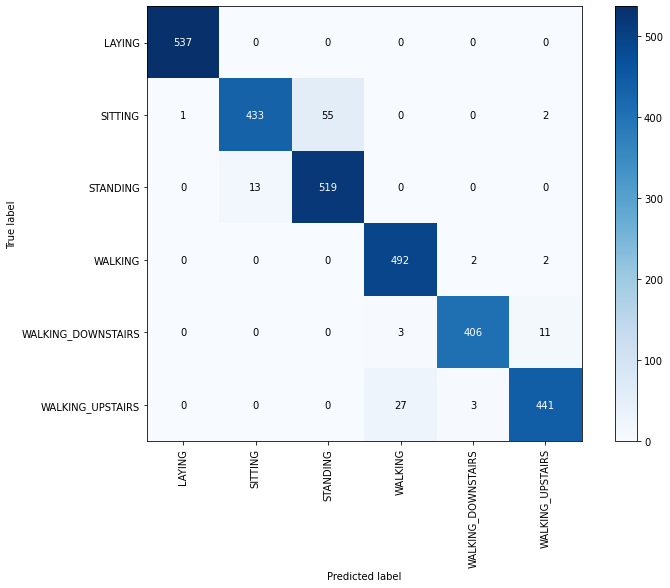

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(cm1, cmap=plt.cm.Blues)
ax.figure.colorbar(ax.imshow(cm1, cmap=plt.cm.Blues), ax=ax)
ax.set(
    xticks=np.arange(cm1.shape[1]),
    yticks=np.arange(cm1.shape[0]),
    xticklabels=np.unique(y_pred1),
    yticklabels=np.unique(y_pred1),
    ylabel="True label",
    xlabel="Predicted label",
)
plt.xticks(rotation = 90)
thresh = cm1.max() / 2.
for i in range(cm1.shape[0]):
        for j in range(cm1.shape[1]):
            ax.text(j, i, int(cm1[i, j]),ha="center", va="center",color="white" if cm1[i, j] > thresh else "black")

### 5. Finding out feature importance

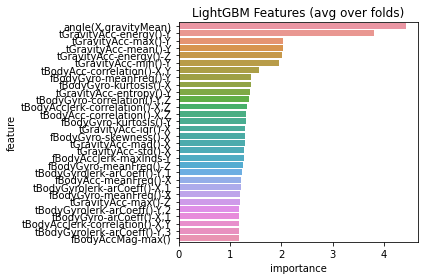

In [20]:
import math
w=logistic_model1.coef_[0]
df2 = pd.DataFrame(df_train.columns, columns = ["feature"])
logistic_feature_importance = df2[:-2]
logistic_feature_importance["importance"] = pow(math.e, w)
logistic_feature_importance = logistic_feature_importance.sort_values(by = ["importance"], ascending=False)
sb.barplot(x="importance", y="feature", data=logistic_feature_importance.sort_values(by="importance", ascending=False).head(30))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

### 6. Grouping similiar feature, dropping them one by one and testing accuracy

In [21]:
main_feature_list = ['fBodyAcc','fBodyGyro','fBodyAccJerk','tGravityAcc','tBodyAcc','tBodyGyroJerk','tBodyGyro','tBodyAccJerk',
                     'tBodyAccMag','tGravityAccMag','tBodyAccJerkMag','tBodyGyroMag','tBodyGyroJerkMag','fBodyAccMag',
                     'fBodyBodyAccJerkMag','fBodyBodyGyroMag','fBodyBodyGyroJerkMag','angle']
for feature in main_feature_list:
    print("drop " + feature)
    X_train_drop_main_feature = x_train.drop(list(x_train.filter(regex = feature)),axis=1)
    X_test_drop_main_feature = x_test.drop(list(x_test.filter(regex = feature)),axis=1)

    logistic_model2 = LogisticRegression()
    logistic_model2.fit(X_train_drop_main_feature, y_train)
    y_pred = logistic_model2.predict(X_test_drop_main_feature)
    accuracy = logistic_model2.score(X_test_drop_main_feature, y_test)
    print("Accuracy after removing current main feature:",accuracy)
    print("\n")

drop fBodyAcc
Accuracy after removing current main feature: 0.9613165931455717


drop fBodyGyro
Accuracy after removing current main feature: 0.9541907024092298


drop fBodyAccJerk
Accuracy after removing current main feature: 0.9575839837122497


drop tGravityAcc
Accuracy after removing current main feature: 0.9521547336274178


drop tBodyAcc
Accuracy after removing current main feature: 0.9524940617577197


drop tBodyGyroJerk
Accuracy after removing current main feature: 0.9535120461486257


drop tBodyGyro
Accuracy after removing current main feature: 0.9412962334577536


drop tBodyAccJerk
Accuracy after removing current main feature: 0.9558873430607397


drop tBodyAccMag
Accuracy after removing current main feature: 0.9582626399728538


drop tGravityAccMag
Accuracy after removing current main feature: 0.9582626399728538


drop tBodyAccJerkMag
Accuracy after removing current main feature: 0.9606379368849678


drop tBodyGyroMag
Accuracy after removing current main feature: 0.959959280

### 7. Accuracy after removing top 10% feature importance

In [22]:
top10p_features = logistic_feature_importance.sort_values(by="importance", ascending=False).head(56)
x_train_afterDrop10p = x_train.drop(top10p_features["feature"],axis=1)
x_test_afterDrop10p = x_test.drop(top10p_features["feature"],axis=1)

hypermodel3 = search.fit(x_train_afterDrop10p,y_train)
accuracy = hypermodel3.score(x_test_afterDrop10p, y_test)
print("Accuracy after removing top 10 percent feature importance:",accuracy)

Accuracy after removing top 10 percent feature importance: 0.9582626399728538


### 8. Accuracy after removing top 30% feature importance

In [23]:
top30p_features = logistic_feature_importance.sort_values(by="importance", ascending=False).head(170)
x_train_afterDrop30p = x_train.drop(top30p_features["feature"],axis=1)
x_test_afterDrop30p = x_test.drop(top30p_features["feature"],axis=1)

hypermodel4 = search.fit(x_train_afterDrop30p,y_train)
accuracy = hypermodel4.score(x_test_afterDrop30p, y_test)
print("Accuracy after removing top 30 percent feature importance:",accuracy)

Accuracy after removing top 30 percent feature importance: 0.9467254835425857


### 9. Accuracy after removing top 50% feature importance

In [24]:
top50p_features = logistic_feature_importance.sort_values(by="importance", ascending=False).head(280)
x_train_afterDrop50p = x_train.drop(top50p_features["feature"],axis=1)
x_test_afterDrop50p = x_test.drop(top50p_features["feature"],axis=1)

hypermodel5 = search.fit(x_train_afterDrop50p,y_train)
accuracy = hypermodel5.score(x_test_afterDrop50p, y_test)
print("Accuracy after removing top 50 percent feature importance:",accuracy)

Accuracy after removing top 50 percent feature importance: 0.9507974211062097


### 10. Retesting by completely removing accelerometer

In [25]:

x_train_DropAcc = df_train.drop(['subject', 'Activity'], axis=1)
x_train_DropAcc = x_train_DropAcc[x_train_DropAcc.columns.drop(list(x_train_DropAcc.filter(regex='Acc')))]
x_test_DropAcc = df_test.drop(['subject', 'Activity'], axis=1)
x_test_DropAcc = x_test_DropAcc[x_test_DropAcc.columns.drop(list(x_test_DropAcc.filter(regex='Acc')))]

hypermodel7 = search.fit(x_train_DropAcc,y_train)
accuracy = hypermodel7.score(x_test_DropAcc, y_test)
print("Acccuracy after removing accelerometer data:",accuracy)


Acccuracy after removing accelerometer data: 0.9114353579911775


### 11. Retesting by completely removing gyroscope

In [26]:
x_train_DropGyro = df_train.drop(['subject', 'Activity'], axis=1)
x_train_DropGyro = x_train_DropGyro[x_train_DropGyro.columns.drop(list(x_train_DropGyro.filter(regex='Gyro')))]
x_test_DropGyro = df_test.drop(['subject', 'Activity'], axis=1)
x_test_DropGyro = x_test_DropGyro[x_test_DropGyro.columns.drop(list(x_test_DropGyro.filter(regex='Gyro')))]

hypermodel8 = search.fit(x_train_DropGyro,y_train)
accuracy = hypermodel8.score(x_test_DropGyro, y_test)
print("Acccuracy after removing gyroscope data:",accuracy)

Acccuracy after removing gyroscope data: 0.9053274516457415
